## OIL DATA ANALYTICS PROJECT

#### SETUP

In [7]:
# Download R libraries for analysis
library(xts)
library(dplyr)
library(ggplot2)
library(quantmod)
library(lubridate)

Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Version 0.4-0 included new data defaults. See ?getSymbols.



In [ ]:
# Download R libraries for Visualization
# install.packages("highcharter")
library(highcharter)

In [2]:
# Connect to Quandl library
library(Quandl)
my_api <- "your_API_key"
Quandl.api_key(my_api)

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




#### Oil Futures Data Exploration

In [3]:
#  Get Historical Futures Prices: Crude Oil Futures from Quandl
CME_CL_Data <- Quandl('CHRIS/CME_CL1')

# Show the first 10 rows of the CME_CL_Data
head(CME_CL_Data, n=10)

,Date,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2020-09-23,39.76,40.75,39.26,39.59,0.13,39.93,313862,369440
2,2020-09-22,39.63,40.02,39.00,39.55,0.29,39.60,15651,18578
3,2020-09-21,40.98,41.27,38.66,39.59,-1.80,39.31,61703,53422
4,2020-09-18,40.97,41.49,40.30,40.97,0.14,41.11,83204,65762
5,2020-09-17,40.19,41.22,39.42,40.97,0.81,40.97,272198,99916
6,2020-09-16,38.35,40.34,38.35,40.17,1.88,40.16,358564,135057
7,2020-09-15,37.28,38.57,37.06,38.39,1.02,38.28,338553,174182
8,2020-09-14,37.32,37.68,36.82,37.26,-0.07,37.26,340039,204256
9,2020-09-11,37.01,37.82,36.67,37.39,0.03,37.33,358077,226703


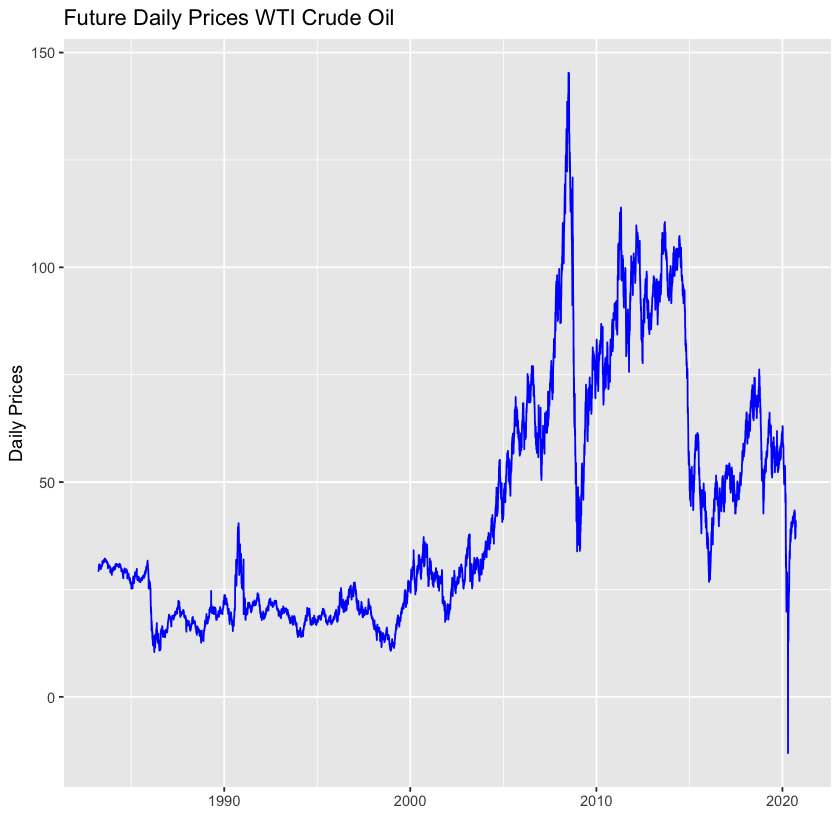

In [4]:
# Plot the last price field of the Crude Oil Futures Historical Prices
ggplot(CME_CL_Data, aes(Date, Last)) + geom_line(color = "blue") + xlab("") + ylab("Daily Prices")+   ggtitle("Future Daily Prices WTI Crude Oil") 

In [14]:
# Inverse the order of CME_CL_Data dataframe to have the oldest data at first and the latest data at the bottom. 
# We would use the arrange command from dplyr to achieve this. The data frame CME_CL_Data_ starts from 
# the oldest data of the CL future continuous series from Quandl
 
CME_CL_Data_ <- CME_CL_Data %>% arrange(rev(rownames(.)))
 
# It seems that dates are not consecutive. This issue was observed when we reverse 
# the series and is present most at the beginning of the series. So, sometimes
# we have nonconsecutive dates in subsequent rows. To avoid this, we will sort
# the CME_CL_DATA_ by consecutive dates. The command arrange from dplyr would # do this task.


CME_CL_Data_ <- CME_CL_Data_ %>%
  mutate(date = as.Date(Date, "%d-%m-%Y")) %>%
  arrange(date)
 
# Calculate the returns  
CME_CL_Data_$returns <- as.numeric(c('NA',diff(log(CME_CL_Data_$Last))))

# Remove outliers from the CME_CL_DATA_ , that are values with daily returns greater than 0.3

CME_CL_Data_ <- CME_CL_Data_[!abs(CME_CL_Data_$returns) > 0.3,]

# Select only numeric columns from the CME_CL_Data_ dataframe in order to summarize   the numeric columns. This can be done with the select_if command from dplyr package

CL_DATA <- select_if(CME_CL_Data_, is.numeric)

# Get the number of NAN values by column
na_cols_count <-sapply(CL_DATA, function(y) sum(length(which(is.na(y)))))
 
# The Change column has a lot of null values. So we would 
# separate this column from the others. Using the select command from dplyr 
# package we can do this task. The c() vector contain the columns position that we want to keep.

CL_DATA <- select(CL_DATA,c(1,2,3,4,6,7,8,9))

# Remove rows with Nan values using complete.cases command
CL_DATA <- CL_DATA[complete.cases(CL_DATA),]

# The statistic function will calculate some metrics such as mean, standard deviation, median, max and min for each of the columns. 

statistics <- do.call(data.frame, 
                      list(mean = round(apply(CL_DATA, 2, mean),4),
                           sd = round(apply(CL_DATA, 2, sd),4),
                           median = round(apply(CL_DATA, 2, median),4),
                           min = round(apply(CL_DATA, 2, min),4),
                         max = round(apply(CL_DATA, 2, max),4)))
statistics

Warning message in log(CME_CL_Data_$Last):
“NaNs produced”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


,mean,sd,median,min,max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Open,43.0841,28.1894,30.3050,10.000,145.190
High,43.6734,28.5449,30.6000,11.020,147.270
Low,42.4641,27.7853,30.0650,9.750,143.220
Last,43.0866,28.1821,30.3500,10.420,145.290
Settle,43.0854,28.1827,30.3500,10.420,145.290
Volume,165923.0403,202970.0341,69802.5000,0.000,1389653.000
Previous Day Open Interest,152385.3273,138798.3584,98033.5000,0.000,642793.000
returns,0.0001,0.0247,0.0004,-0.285,0.218


#### Exploring Oil Prices Data: WTI, BRENT, ARAB LIGHT

In [49]:
# WTI monthly data
WTI <- Quandl("FRED/DCOILWTICO", 
                    type = "xts", 
                    collapse = "monthly",  
                    start_date = "1990-01-01", 
                    end_date = "2020-09-01")
index(WTI) <- seq(mdy('01/01/1990'), mdy(last(index(WTI))), by = 'months')
str(WTI)
head(WTI)

An ‘xts’ object on 1990-01-01/2020-09-01 containing:
  Data: num [1:369, 1] 22.7 21.6 20.3 18.5 17.5 ...
  Indexed by objects of class: [Date] TZ: UTC
  xts Attributes:  
 NULL


            [,1]
1990-01-01 22.69
1990-02-01 21.55
1990-03-01 20.34
1990-04-01 18.50
1990-05-01 17.47
1990-06-01 17.05

In [50]:
# BRENT monthly data
BRENT <- Quandl("FRED/DCOILBRENTEU", 
                    type = "xts", 
                    collapse = "monthly",  
                    start_date = "1990-01-01", 
                    end_date = "2020-09-01")
index(BRENT) <- seq(mdy('01/01/1990'), mdy(last(index(BRENT))), by = 'months')
str(BRENT)
head(BRENT)

An ‘xts’ object on 1990-01-01/2020-09-01 containing:
  Data: num [1:369, 1] 20.5 19.2 17.9 16.4 15.3 ...
  Indexed by objects of class: [Date] TZ: UTC
  xts Attributes:  
 NULL


            [,1]
1990-01-01 20.50
1990-02-01 19.20
1990-03-01 17.95
1990-04-01 16.35
1990-05-01 15.30
1990-06-01 15.73

In [ ]:
EIA/PET_ISA4990008_A

In [64]:
# ARAB LIGHT monthly data
ARAB_LIGHT <- Quandl("EIA/PET_ISA4990008_M", 
                    type = "xts", start_date = "1990-01-01", 
                    end_date = "2020-09-01")
#index(ARAB_LIGHT) <- seq(mdy('01/01/1990'), mdy(last(index(ARAB_LIGHT))), by = 'months')
str(ARAB_LIGHT)
head(ARAB_LIGHT)

An ‘xts’ object on Jan 1990/May 2020 containing:
  Data: num [1:358, 1] 19.7 18.7 16.8 14.9 14.7 ...
  Indexed by objects of class: [yearmon] TZ: UTC
  xts Attributes:  
 NULL


          [,1]
Jan 1990 19.73
Feb 1990 18.71
Mar 1990 16.76
Apr 1990 14.86
May 1990 14.72
Jun 1990 15.48

In [66]:
oil_data <- merge(WTI,BRENT, ARAB_LIGHT, all=TRUE)
hchart(oil_data)

HTML widgets cannot be represented in plain text (need html)

In [84]:
# Russian Oil URALS: Quandl("BANKRUSSIA/KEYECIND", api_key="xq44Ss4a-fZGqgecyG1o")
str(oil_data)
oil_data_ts <- as.ts(oil_data)
head(oil_data_ts)
str(oil_data_ts)
is.ts(oil_data_ts)

An ‘xts’ object on 1990-01-01/2020-09-01 containing:
  Data: num [1:369, 1:3] 22.7 21.6 20.3 18.5 17.5 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:3] "WTI" "BRENT" "ARAB_LIGHT"
  Indexed by objects of class: [Date] TZ: UTC
  xts Attributes:  
 NULL


WTI,BRENT,ARAB_LIGHT
22.69,20.50,19.73
21.55,19.20,18.71
20.34,17.95,16.76
18.50,16.35,14.86
17.47,15.30,14.72
17.05,15.73,15.48


 Time-Series [1:369, 1:3] from 1 to 369: 22.7 21.6 20.3 18.5 17.5 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:3] "WTI" "BRENT" "ARAB_LIGHT"


[1] TRUE

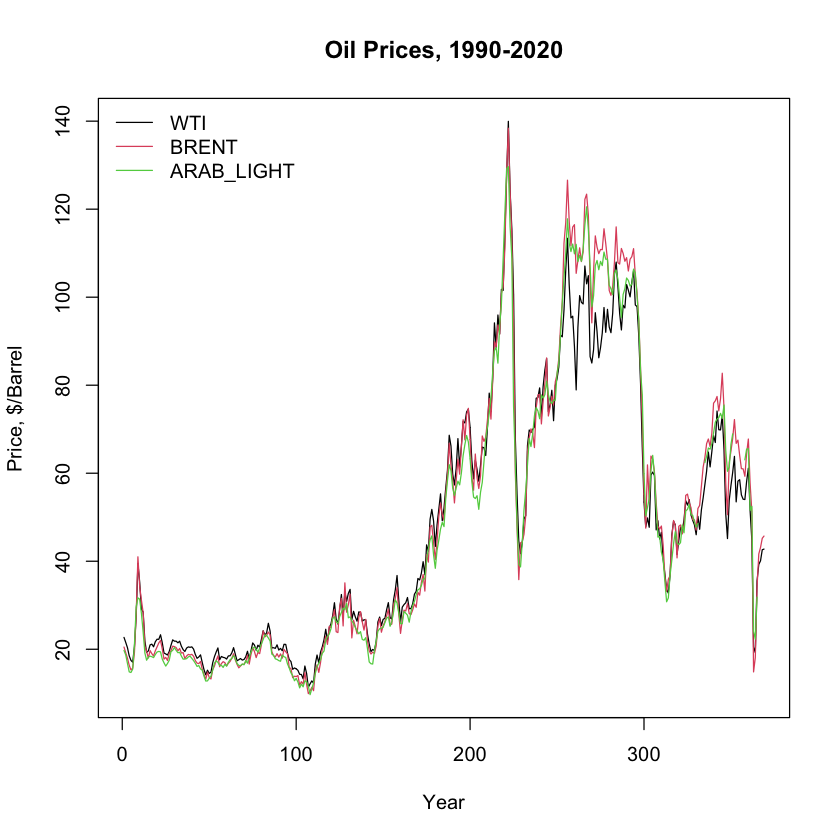

In [86]:
# Use ts.plot with eu_stocks
ts.plot(oil_data_ts, col = 1:3, xlab = "Year", ylab = "Price, $/Barrel", main = "Oil Prices, 1990-2020")

# Add a legend to your ts.plot
legend("topleft", colnames(oil_data_ts), lty = 1, col = 1:3, bty = "n")


In [81]:
# WTI monthly data
wti_zoo <- Quandl("FRED/DCOILWTICO", 
                    type = "zoo", 
                    collapse = "monthly",  
                    start_date = "1990-01-01", 
                    end_date = "2020-09-01")
# index(WTI) <- seq(mdy('01/01/1990'), mdy(last(index(WTI))), by = 'months')
str(wti_zoo)
wti_ts <- as.ts(wti_zoo)
head(wti_ts)
is.ts(wti_ts)

‘zooreg’ series from Jan 1990 to Sep 2020
  Data: num [1:369] 22.7 21.6 20.3 18.5 17.5 ...
  Index:  'yearmon' num [1:369] Jan 1990 Feb 1990 Mar 1990 Apr 1990 ...
  Frequency: 12 


[1] 22.69 21.55 20.34 18.50 17.47 17.05

[1] TRUE

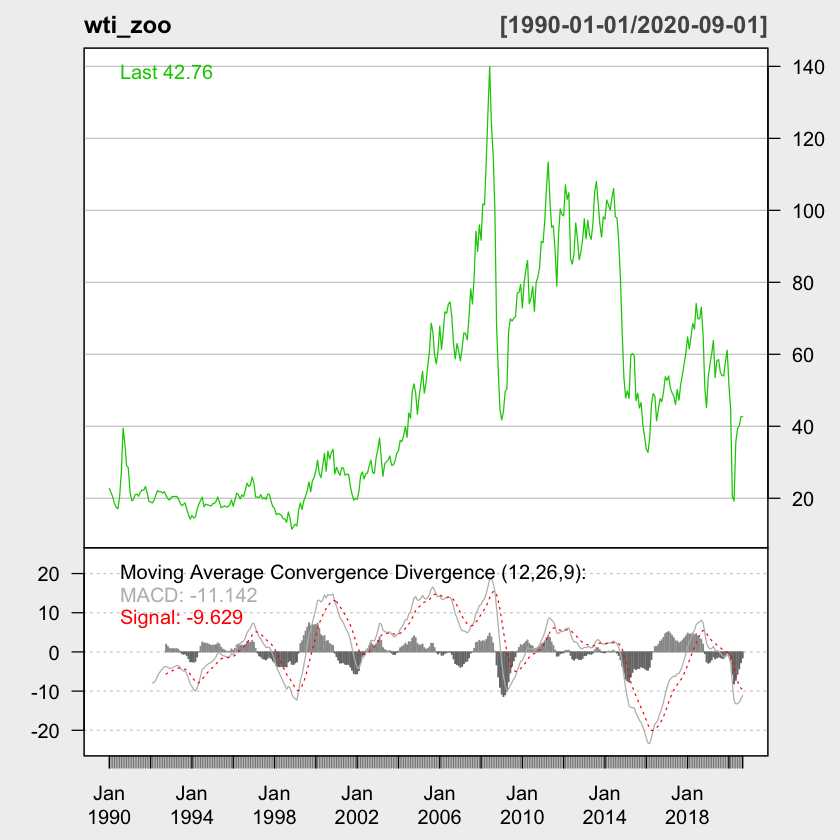

In [82]:
chartSeries(wti_zoo, theme="white", TA=c(addMACD(),addVo()))

In [77]:
oil_statistics <- do.call(data.frame, 
                      list(mean = round(apply(oil_data, 2, mean),4),
                           sd = round(apply(oil_data, 2, sd),4),
                           median = round(apply(oil_data, 2, median),4),
                           min = round(apply(oil_data, 2, min),4),
                         max = round(apply(oil_data, 2, max),4)))
oil_statistics

,mean,sd,median,min,max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WTI,47.7392,29.1515,41.54,11.37,139.96
BRENT,49.0501,32.6745,41.00,9.91,138.40
ARAB_LIGHT,NA,NA,NA,NA,NA


#### Time-Series Analysis in R